Libraries and functions that need to be loaded:

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras.datasets import cifar10
from keras.utils import to_categorical   
from sklearn.model_selection import train_test_split

def load_cifar10():

    (X_train, y_train), (X_test_val, y_test_val) = cifar10.load_data() #automatically gives train (80), val (20)
    #split val in half to get our val (10), test(10)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=True, stratify=y_test_val)

    return X_train, y_train, X_val, y_val, X_test, y_test


2023-12-15 05:24:25.496995: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 05:24:25.551776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 05:24:25.551839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 05:24:25.553213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 05:24:25.561949: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 05:24:25.562763: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

In [8]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization

num_classes = 10

def get_model(simple=True):

    model = Sequential()

    if simple:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10
    else:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

    return model


In [9]:
np.random.seed(42)

# this removes an entire class
def split_to_retain_and_forget(X, y, unlearn_class_label):
    retain_mask = (y != unlearn_class_label).squeeze(axis=1)
    
    X_retain = X[retain_mask]
    y_retain = y[retain_mask]
    
    forget_mask = (y == unlearn_class_label).squeeze(axis=1)
    
    X_forget = X[forget_mask]
    y_forget = y[forget_mask]

    return X_retain, y_retain, X_forget, y_forget

#Since the forget set only includes examples of one label, it doesn't get converted to a proper one hot encoding, so we need to force it.
def pad_array(original_array, desired_length):
    num_zeros_to_pad = max(0, desired_length - original_array.shape[1])
    padded_array = np.pad(original_array, ((0, 0), (0, num_zeros_to_pad)), mode='constant', constant_values=0)

    return padded_array

# this splits off a certain number of examples of a class
def split_to_retain_and_forget_examples(X, y, unlearn_class_label, num_example):
    retain_mask = (y != unlearn_class_label).squeeze(axis=1)
    forget_mask = (y == unlearn_class_label).squeeze(axis=1)

    forget_indices = np.where(forget_mask)[0]

    if num_example > len(forget_indices):
        raise ValueError("num_example cannot be larger than the number of available examples")
    else:
        forget_subset = np.random.choice(forget_indices, size=num_example, replace=False)

    X_forget = X[forget_subset]
    y_forget = y[forget_subset]

    retain_subset = np.setdiff1d(forget_indices, forget_subset)
    X_retain = np.concatenate((X[retain_mask], X[retain_subset]), axis=0)
    y_retain = np.concatenate((y[retain_mask], y[retain_subset]), axis=0)

    return X_retain, y_retain, X_forget, y_forget

In [10]:
unlearn_class = 6
X_train_retain, y_train_retain, X_train_forget, y_train_forget = split_to_retain_and_forget_examples(X_train, y_train, unlearn_class, num_example=10)
X_val_retain, y_val_retain, X_val_forget, y_val_forget = split_to_retain_and_forget(X_val, y_val, unlearn_class)
X_test_retain, y_test_retain, X_test_forget, y_test_forget = split_to_retain_and_forget(X_test, y_test, unlearn_class)


In [11]:
adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

# Membership Inference Attack

Initial Model:

In [30]:
from scipy import special

student = get_model(simple=False)

student.load_weights("initial_trained_model/model_weights.85-0.87.h5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 53s 68ms/step
Predict on test...
1/1 [==============================] - 0s 27ms/step
Apply softmax to get probabilities from logits...
Compute losses...


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tensorflow_privacy/privacy/privacy_tests/epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.96 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.90 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 8.9930, 8.7166, 8.6871, 8.3385, 8.2911 on slice Entire dataset


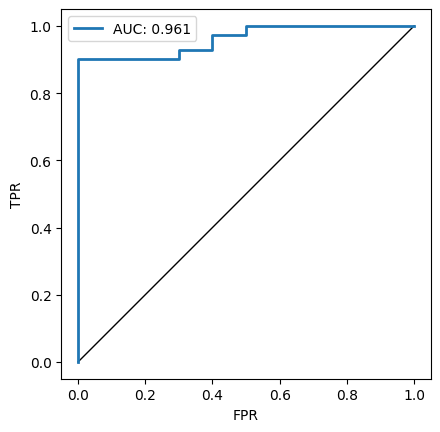

In [29]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                 SlicingSpec(entire_dataset = True),
                                 attack_types = [
                                     #AttackType.THRESHOLD_ATTACK,
                                     AttackType.LOGISTIC_REGRESSION])
                                     #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                     #AttackType.MULTI_LAYERED_PERCEPTRON])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


Retrained Model:

In [31]:
from scipy import special

student = get_model(simple=False)

student.load_weights("retain_set_trained_model/model_weights.80-0.88.h5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 54s 68ms/step
Predict on test...
1/1 [==============================] - 0s 48ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.61 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.48 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 0.5867, 0.5867, 0.5866, 0.5866, 0.5865 on slice Entire dataset


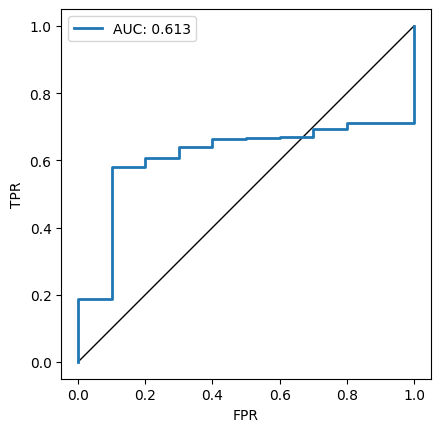

In [21]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

  # Run several attacks for different data slices
  attacks_result = mia.run_attacks(input,
                                  SlicingSpec(entire_dataset = True),
                                  attack_types = [
                                      #AttackType.THRESHOLD_ATTACK,
                                      AttackType.LOGISTIC_REGRESSION])
                                      #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                      #AttackType.MULTI_LAYERED_PERCEPTRON])



# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


Finetuning:

In [82]:
from scipy import special

student = get_model(simple=False)

student.load_weights("finetune_retain_set/model_weights.50-0.88.h5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 58s 74ms/step
Predict on test...
1/1 [==============================] - 0s 35ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.95 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.90 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 8.3385, 8.0037, 7.7461, 7.5728, 7.2806 on slice Entire dataset


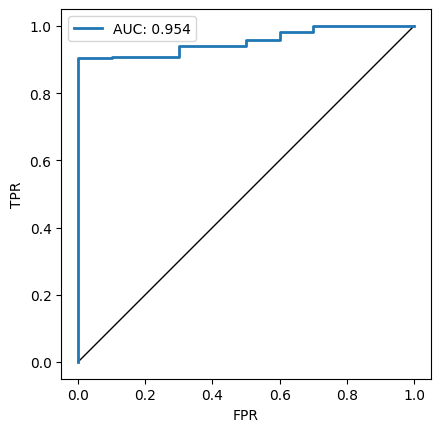

In [84]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


Finetuning with Pruning:

In [89]:
from scipy import special

student = get_model(simple=False)

student.load_weights("pruned/model_weights_pruned0.25.10-0.86.h5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 52s 67ms/step
Predict on test...
1/1 [==============================] - 0s 30ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.89 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.70 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 1.8802, 1.8799, 1.8796, 1.8794, 1.8791 on slice Entire dataset


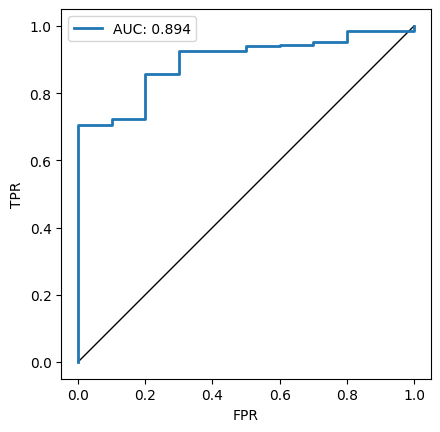

In [94]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


In [95]:
from scipy import special

student = get_model(simple=False)

student.load_weights("pruned/model_weights_pruned0.35.10-0.84.h5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 53s 67ms/step
Predict on test...
1/1 [==============================] - 0s 30ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.85 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.64 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 1.3087, 1.3086, 1.3085, 1.3084, 1.3082 on slice Entire dataset


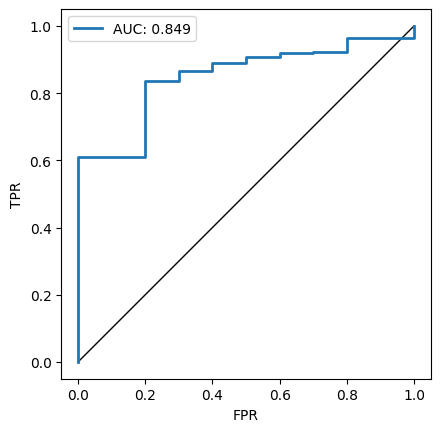

In [100]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


Student Teacher No Prune:

In [119]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-no-prune/alpha0.8.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 53s 68ms/step
Predict on test...
1/1 [==============================] - 0s 35ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.77 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.70 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 1.8020, 1.8018, 1.8016, 1.8014, 1.8012 on slice Entire dataset


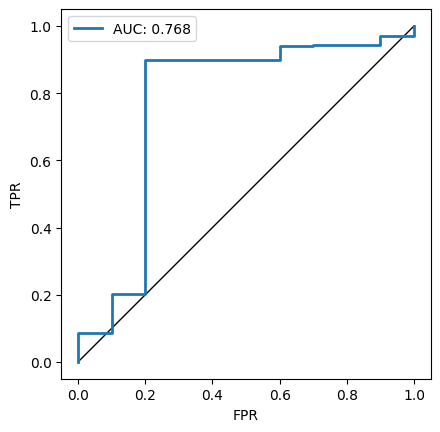

In [134]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


In [108]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-no-prune/alpha0.5.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 47s 61ms/step
Predict on test...
1/1 [==============================] - 0s 27ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.86 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.80 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 1.9956, 1.9954, 1.9952, 1.9950, 1.9948 on slice Entire dataset


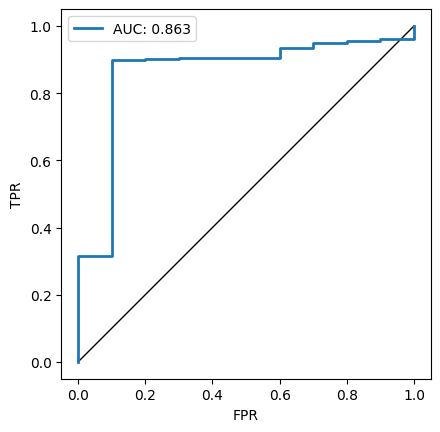

In [137]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


In [135]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-no-prune/alpha0.25.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 52s 66ms/step
Predict on test...
1/1 [==============================] - 0s 31ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.91 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.79 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 1.9682, 1.9680, 1.9678, 1.9676, 1.9674 on slice Entire dataset


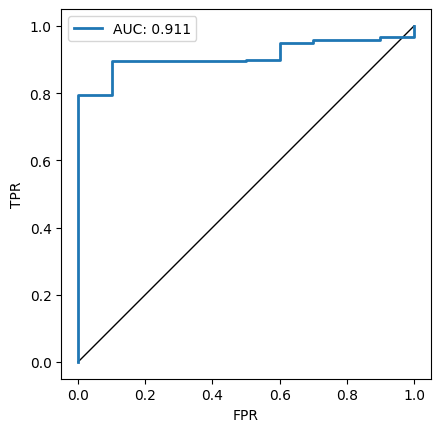

In [136]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


Student Teacher with Pruning:

In [15]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-prune/prune0.05.alpha0.8.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 55s 70ms/step
Predict on test...
1/1 [==============================] - 0s 40ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.75 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.70 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 1.0360, 1.0359, 1.0359, 1.0358, 1.0357 on slice Entire dataset


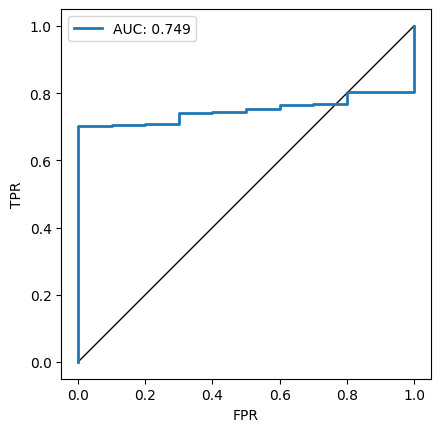

In [23]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


In [18]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-prune/prune0.1.alpha0.25.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 53s 68ms/step
Predict on test...
1/1 [==============================] - 0s 32ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.70 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.61 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 0.8253, 0.8252, 0.8252, 0.8251, 0.8251 on slice Entire dataset


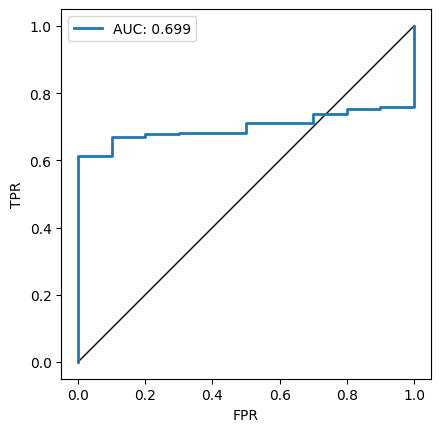

In [81]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])


# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


In [20]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-prune/prune0.1.alpha0.5.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 54s 69ms/step
Predict on test...
1/1 [==============================] - 0s 43ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.74 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.68 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 0.9782, 0.9781, 0.9780, 0.9780, 0.9779 on slice Entire dataset


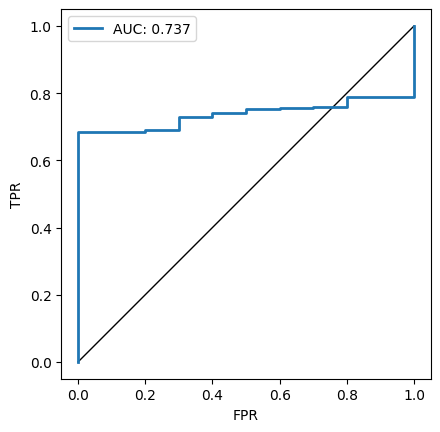

In [17]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))


In [22]:
from scipy import special

student = get_model(simple=False)

student.load_weights("student-teacher-prune/prune0.1.alpha0.65.20.hdf5")

student.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Predict on train...')
logits_train = student.predict(X_train_retain, batch_size=64)
print('Predict on test...')
logits_test = student.predict(X_train_forget, batch_size=64)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

adjusted_y_train_forget = to_categorical(y_train_forget)

desired_length = 10

adjusted_y_train_forget = pad_array(adjusted_y_train_forget, desired_length)

loss_train = cce(constant(to_categorical(y_train_retain)), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(adjusted_y_train_forget), constant(prob_test), from_logits=False).numpy()

Predict on train...
782/782 [==============================] - 55s 70ms/step
Predict on test...
1/1 [==============================] - 0s 31ms/step
Apply softmax to get probabilities from logits...
Compute losses...


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an AUC of 0.74 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved an advantage of 0.68 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved a positive predictive value of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49990 training and 10 test examples) achieved top-5 epsilon lower bounds of 0.9650, 0.9649, 0.9648, 0.9648, 0.9647 on slice Entire dataset


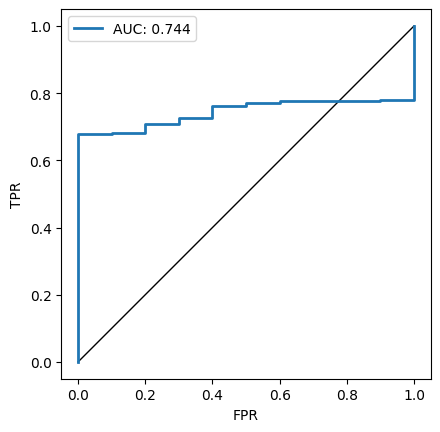

In [19]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import warnings
warnings.filterwarnings("ignore")

labels_train = np.argmax(to_categorical(y_train_retain), axis=1)
labels_test = np.argmax(adjusted_y_train_forget, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                SlicingSpec(entire_dataset = True),
                                attack_types = [
                                    #AttackType.THRESHOLD_ATTACK,
                                    AttackType.LOGISTIC_REGRESSION])
                                    #AttackType.THRESHOLD_ENTROPY_ATTACK,
                                    #AttackType.MULTI_LAYERED_PERCEPTRON])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

print(attacks_result.summary(by_slices=True))
